# FET445 - Veri Madenciliği Projesi: Araç Fiyat Tahmin Modeli
### Grup Üyesi:Ömer Utku Aktemur] -22040301043]
### Yöntem: PCA (Principal Component Analysis) ile Boyut İndirgeme

Bu çalışmada, temizlenmiş 2. el araç verisi kullanılarak fiyat tahmini (Regresyon) yapılacaktır. Grubumuz veri temizliğini ortak yürütmüş, ancak özellik seçimi ve modelleme aşamalarında ayrışmıştır.

Bu notebook dosyasında, **PCA (Temel Bileşen Analizi)** yöntemiyle veri setinin boyutunu indirgeyecek ve **Ridge Regression** ile **SVR** modellerinin performanslarını PCA öncesi ve sonrası durumlar için karşılaştıracağım.

## 1. Kütüphanelerin Yüklenmesi
Veri işleme, görselleştirme ve makine öğrenmesi algoritmaları için gerekli Python kütüphaneleri yüklenmektedir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn Modülleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score

# Uyarıları gizle (Temiz görünüm için)
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## 2. Veri Setinin Yüklenmesi
Grup arkadaşlarımızla ortaklaşa temizlediğimiz `ekip_odevi_temizlenmis_veri.csv` dosyası kullanılacaktır. Bu veri seti eksik verilerden arındırılmış ve temel temizlik işlemleri yapılmıştır.

In [ ]:
# Temizlenmiş veriyi oku
df = pd.read_csv('ekip_odevi_temizlenmis_veri.csv')

# Veri setinin boyutunu ve ilk 5 satırını kontrol et
print(f"Veri Seti Boyutu: {df.shape}")
df.head()

Veri Seti Boyutu: (29585, 10)


,marka,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,skoda,Kamiq,2019.0,21990.0,Semi-Auto,563.0,Diesel,145.0,52.3,1.6
1,audi,Q5,2016.0,20498.0,Semi-Auto,33657.0,Diesel,200.0,47.1,2.0
2,vw,Touareg,2019.0,39995.0,Semi-Auto,7000.0,Diesel,145.0,34.5,3.0
3,toyota,Aygo,2019.0,8690.0,Manual,2438.0,Petrol,145.0,56.5,1.0
4,ford,S-MAX,2020.0,34498.0,Semi-Auto,4623.0,Diesel,145.0,43.5,2.0


### 2.1. Kategorik Değişkenlerin Sayısallaştırılması (Encoding)
Makine öğrenmesi modelleri metin verisiyle çalışamaz. Bu nedenle kategorik sütunları sayısal formata çeviriyoruz:
1.  **Label Encoding:** `model` sütunu çok fazla çeşitlilik içerdiği için (A3, Fiesta, Golf vb.) bu sütunu 0, 1, 2 gibi sayılara atıyoruz.
2.  **One-Hot Encoding:** `marka`, `fuelType` ve `transmission` gibi daha az sınıfa sahip sütunları 0 ve 1'lerden oluşan vektörlere dönüştürüyoruz.

In [ ]:
# Label Encoding (Model sütunu için)
le = LabelEncoder()
df['model'] = le.fit_transform(df['model'])

# One-Hot Encoding
# drop_first=True ile dummy variable tuzağından kaçınıyoruz
df = pd.get_dummies(df, columns=['marka', 'fuelType', 'transmission'], drop_first=True)

print("Encoding sonrası veri boyutu:", df.shape)
df.head()

Encoding sonrası veri boyutu: (29585, 60)


,model,year,price,mileage,tax,mpg,engineSize,marka_bmw,marka_cclass,marka_focus,...,fuelType_48,fuelType_6,fuelType_9,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Other,transmission_Semi-Auto
0,90,2019.0,21990.0,563.0,145.0,52.3,1.6,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,115,2016.0,20498.0,33657.0,200.0,47.1,2.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,150,2019.0,39995.0,7000.0,145.0,34.5,3.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,24,2019.0,8690.0,2438.0,145.0,56.5,1.0,False,False,False,...,False,False,False,False,False,False,True,True,False,False
4,127,2020.0,34498.0,4623.0,145.0,43.5,2.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True


## 3. Veri Ayırma ve Ölçeklendirme (Scaling)
Model başarısını doğru ölçmek için veri setini **%80 Eğitim (Train)** ve **%20 Test** seti olarak ikiye ayırıyoruz.

Ayrıca, kullanacağımız **PCA** ve **SVR** algoritmaları veri ölçeğine karşı çok hassastır. Örneğin, "Fiyat" sütunu binlerce ifade edilirken "Motor Hacmi" 1-2 civarındadır. Bu dengesizliği gidermek için `StandardScaler` kullanarak tüm verileri standartlaştırıyoruz (Ortalama=0, Varyans=1).

In [4]:
# Hedef (y) ve Özellikler (X) ayrımı
X = df.drop('price', axis=1)
y = df['price']

# Train-Test Split (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaler Uygulaması
scaler = StandardScaler()

# Sadece eğitim setine fit ediyoruz, test setini buna göre dönüştürüyoruz (Data Leakage önlemi)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Eğitim Seti Boyutu:", X_train_scaled.shape)
print("Test Seti Boyutu:", X_test_scaled.shape)

Eğitim Seti Boyutu: (23668, 59)
Test Seti Boyutu: (5917, 59)


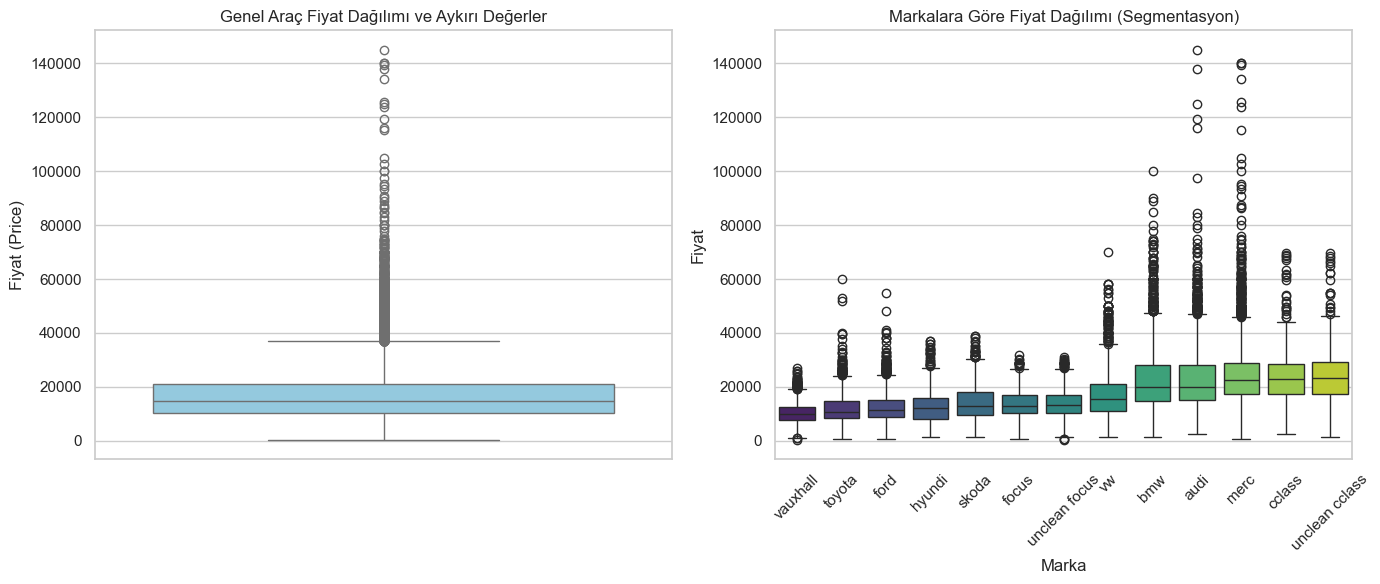

>>> İSTATİSTİKSEL ÖZET:
Alt Çeyrek (Q1): 10300.0
Üst Çeyrek (Q3): 20950.0
IQR (Çeyrekler Açıklığı): 10650.0
Potansiyel Aykırı Değer Sınırı: 36925.0 üzerindeki fiyatlar.


In [ ]:

# GÖRSELLEŞTİRME: BOX PLOT (KUTU GRAFİĞİ)


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Veriyi Oku
df_viz = pd.read_csv('ekip_odevi_temizlenmis_veri.csv')

# Grafik Ayarları
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# GRAFİK 1: Genel Fiyat Dağılımı (Aykırı Değerleri Gösterir)
plt.subplot(1, 2, 1)
sns.boxplot(y=df_viz['price'], color='skyblue')
plt.title('Genel Araç Fiyat Dağılımı ve Aykırı Değerler', fontsize=12)
plt.ylabel('Fiyat (Price)')

# GRAFİK 2: Markalara Göre Fiyat Dağılımı (Kıyaslama)
plt.subplot(1, 2, 2)
# Fiyatı çok yüksek olan markaları daha net görmek için sıralama yapalım
sorted_idx = df_viz.groupby('marka')['price'].median().sort_values().index
sns.boxplot(x='marka', y='price', data=df_viz, order=sorted_idx, palette='viridis')

plt.title('Markalara Göre Fiyat Dağılımı (Segmentasyon)', fontsize=12)
plt.xlabel('Marka')
plt.ylabel('Fiyat')
plt.xticks(rotation=45) # Marka isimleri sığsın diye eğik yaz

plt.tight_layout()
plt.show()

# İstatistiksel Yorum (Otomatik Çıktı)
print(">>> İSTATİSTİKSEL ÖZET:")
Q1 = df_viz['price'].quantile(0.25)
Q3 = df_viz['price'].quantile(0.75)
IQR = Q3 - Q1
ust_sinir = Q3 + 1.5 * IQR

print(f"Alt Çeyrek (Q1): {Q1}")
print(f"Üst Çeyrek (Q3): {Q3}")
print(f"IQR (Çeyrekler Açıklığı): {IQR}")
print(f"Potansiyel Aykırı Değer Sınırı: {ust_sinir} üzerindeki fiyatlar.")